# Introduction

A price estimator for the Boston Airbnb listings is established using LinearRegression and RidgeCV model from sklearn. 

The data is first imported as dataframe and then initially cleaned by a few observations, such as removing the dollar sign in the price values and percentage sign in the rate values. Futher cleaning includes: (1) removing columns with more than 50 percents of nan, (2) removing outliers (price < 20 or > 500) based on the price distribution. 

The data is visulized with basemap for the price distribution in the Boston area, and categorical analysis are performed using boxplot for a few selected interested variables. The missing values of numerical variebles are imputed with mean, and the heatmap of nummerical variables corr with price is generated.

Selected categorical variables are encoded with dummy variables. Then the best combinations of the numbers of the top corr numerical and categorical variebles are identified. Linear regression is performed, and the best r2 score is obtained.

RidgeCV is perfomed to see if the r2 score can be improved.

# Questions to answer in the end of this analysis
## What are the top factors affect the listing price? 
## How does the factors affect the listing price? increase or decrease?
## Can we predict the listing price in Boston? How to select variables?

# Import packages and read data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from mpl_toolkits.basemap import Basemap 
plt.style.use("seaborn-colorblind")
%matplotlib inline

listings = pd.read_csv('./data/listings.csv')
pd.set_option('display.max_columns', 100)
print (listings.shape)
listings.head()

(3585, 95)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

# Data cleaning

In [2]:
# Drop some columns that are not related to price
dropcol = ['id', 'host_id', 'listing_url','scrape_id','jurisdiction_names','license','thumbnail_url',
           'medium_url','picture_url','xl_picture_url','host_thumbnail_url',
           'host_picture_url']
listings.drop(dropcol, axis=1, inplace=True)
listings.shape

(3585, 83)

In [3]:
# find the columns with price involved and observe the data
price_cols_index = listings.columns[listings.columns.str
                                    .contains('cleaning_fee|deposit|price|extra_people') == True]
price_cols = listings[price_cols_index]
print ('price_cols_index:')
print (price_cols_index)
price_cols.head()

price_cols_index:
Index(['price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'extra_people'],
      dtype='object')


,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,$250.00,NaN,NaN,NaN,$35.00,$0.00
1,$65.00,$400.00,NaN,$95.00,$10.00,$0.00
2,$65.00,$395.00,"$1,350.00",NaN,NaN,$20.00
3,$75.00,NaN,NaN,$100.00,$50.00,$25.00
4,$79.00,NaN,NaN,NaN,$15.00,$0.00


In [4]:
# romove $ in the price value and change the data type to float
for variable in price_cols_index:
    listings[variable] = listings[variable].map(lambda x: x.replace("$",'').replace(",",''),
                                              na_action = 'ignore')
    listings[variable] = listings[variable].astype(float)
listings[price_cols_index].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,250.0,NaN,NaN,NaN,35.0,0.0
1,65.0,400.0,NaN,95.0,10.0,0.0
2,65.0,395.0,1350.0,NaN,NaN,20.0
3,75.0,NaN,NaN,100.0,50.0,25.0
4,79.0,NaN,NaN,NaN,15.0,0.0


In [5]:
# remove % in the rating value and change the data type to float
rate_cols_index = listings.columns[listings.columns.str.contains('rate') == True]
rate_cols = listings[rate_cols_index]
print ('rate_cols_index:')
print (rate_cols_index)
rate_cols.head()

rate_cols_index:
Index(['host_response_rate', 'host_acceptance_rate'], dtype='object')


,host_response_rate,host_acceptance_rate
0,NaN,NaN
1,100%,100%
2,100%,88%
3,100%,50%
4,100%,100%


In [6]:
# romove % in the rate value and change the data type to float
for variable in rate_cols_index:
    listings[variable] = listings[variable].map(lambda x: x.replace("%",''),
                                              na_action = 'ignore')
    listings[variable] = listings[variable].astype(float)
listings[rate_cols_index ].head()

,host_response_rate,host_acceptance_rate
0,NaN,NaN
1,100.0,100.0
2,100.0,88.0
3,100.0,50.0
4,100.0,100.0


In [7]:
# find the columns that have more than 50% data as nan
nan_cols = listings.columns[listings.isnull().mean() > 0.50]
print ('nan_cols')
print (nan_cols)
# drop the columns with more than 50% data missing
listings_dropna = listings.drop(nan_cols, axis=1)
listings_dropna.shape

nan_cols
Index(['notes', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price',
       'monthly_price', 'security_deposit', 'has_availability'],
      dtype='object')


(3585, 76)

In [8]:
# amenities are one important variable that affect the price, observe the first data 
pd.set_option('display.max_columns', 100)
listings_dropna['amenities'].head(10)
amenities_col = listings_dropna['amenities']
print ('amenities_col[0]:')
print (amenities_col[0])
# extract the number of amenities as one new numerical variables
listings_dropna['n_amenities'] = amenities_col.apply(lambda x: len(x.split(',')))
# drop the amenities col
listings_dropna.drop('amenities', axis=1, inplace=True)
listings_dropna['n_amenities'].head()

amenities_col[0]:
{TV,"Wireless Internet",Kitchen,"Free Parking on Premises","Pets live on this property",Dog(s),Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo,"Laptop Friendly Workspace"}


0    15
1    21
2    18
3    23
4    14
Name: n_amenities, dtype: int64

In [9]:
listings_dropna.shape

(3585, 76)

## Observation from the price distribution
1. It follows positive distribution, 75% of the data are in the range below 220 USD.  
2. In this study, the price range is selected in the range 20 to 500 USD, which is reasonable for an Airbnb listing price and also falls into people's expection 

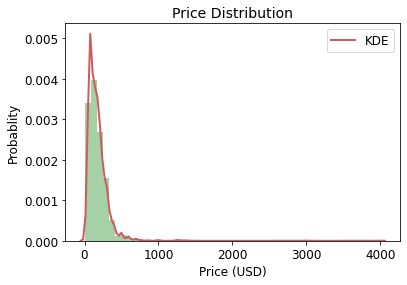

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [10]:
# histogram plot to see the price distribution
sns.distplot(listings_dropna['price'], color='forestgreen',
             kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
plt.title('Price Distribution', fontsize=14)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['KDE'], prop={"size":12})
plt.show()
# price description
listings_dropna.describe().price

## Remove outliers

In [11]:
# retain the data where the price range is in $20 to $500
listings_new = listings_dropna[(listings_dropna['price'] >20) & 
                                  (listings_dropna['price'] <500)]
listings_new.shape

(3491, 76)

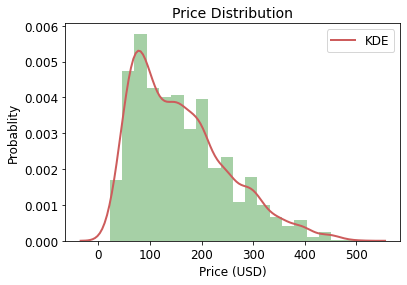

count    3491.000000
mean      159.668863
std        90.922800
min        22.000000
25%        85.000000
50%       147.000000
75%       210.000000
max       499.000000
Name: price, dtype: float64

In [12]:
# histogram plot to see the price distribution in the selcted range < $500
sns.distplot(listings_new['price'], bins=20, color='forestgreen',
             kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
plt.title('Price Distribution', fontsize=14)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['KDE'], prop={"size":12})
plt.show()
# price description
listings_new.describe().price

# Data visualization 
## Basemap plot
Observation: one obvious trend is that the high price listings are most in the city center, and the low price listings are most in the suburb, which makes common sense. 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


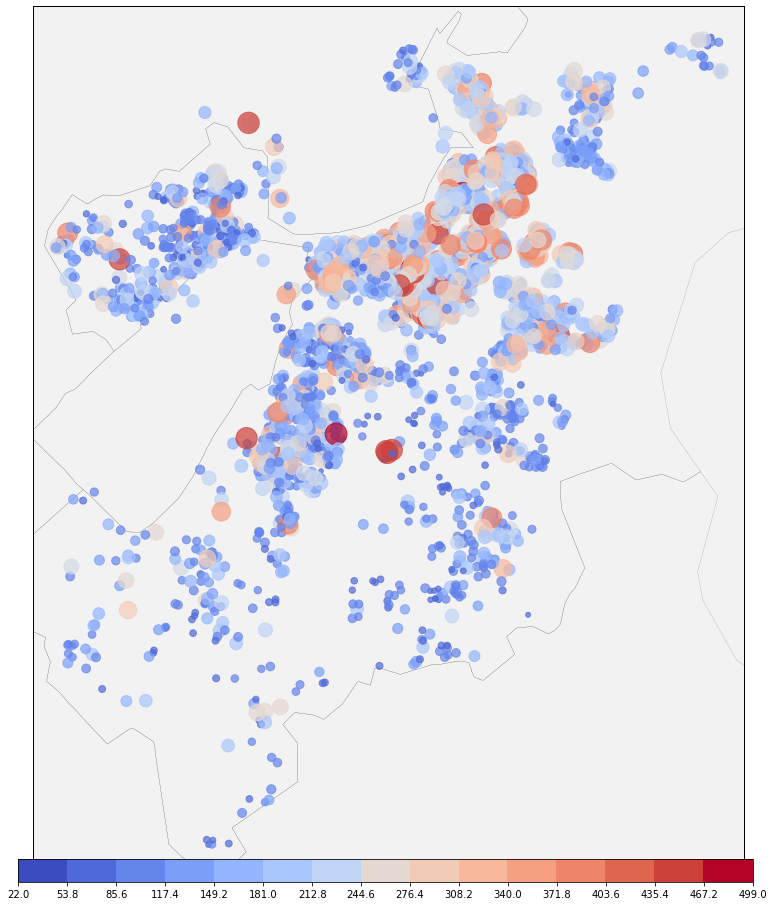

In [13]:
lat_max = listings_new.latitude.max()
lat_min = listings_new.latitude.min()
lon_max = listings_new.longitude.max()
lon_min = listings_new.longitude.min()
edge = 0.006

fig = plt.figure(figsize=(17,16))
m = Basemap(projection='merc', llcrnrlat=lat_min-edge, urcrnrlat=lat_max+edge, llcrnrlon=lon_min-edge, urcrnrlon=lon_max+edge)
# m.drawmapboundary(fill_color='aqua')
m.drawmapboundary(fill_color=[0.95, 0.95, 0.95, 1  ])
m.drawcounties(linewidth=0.1, linestyle='-', color='k', antialiased=1, facecolor='none', ax=None, zorder=None, drawbounds=False)

num_colors =16
values = listings_new.price
price_min = values.min()
price_max = values.max()

cm = plt.get_cmap('coolwarm',num_colors)
bins = np.linspace(values.min(), values.max(), num_colors)

color = cm (np.digitize(values, bins))


x,y = m(listings_new.longitude.values, listings_new.latitude.values)
scat = m.scatter(x,y, s = listings_new.price, color = color, alpha=0.7)
# Draw color legend.
                        #[left, top, width, height]
ax_legend = fig.add_axes([0.21, 0.12, 0.6, 0.02])
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cm, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])
plt.box(False)
cb.ax.set_frame_on(False)
plt.show()

## Box plot for catorgorical variables
### Neighbourhood
Observation: as expected, the top price neighbourhoods are Leather District, Downtown, Chinatown and South Boston Waterfront, where are the business, food, and tourist center. 

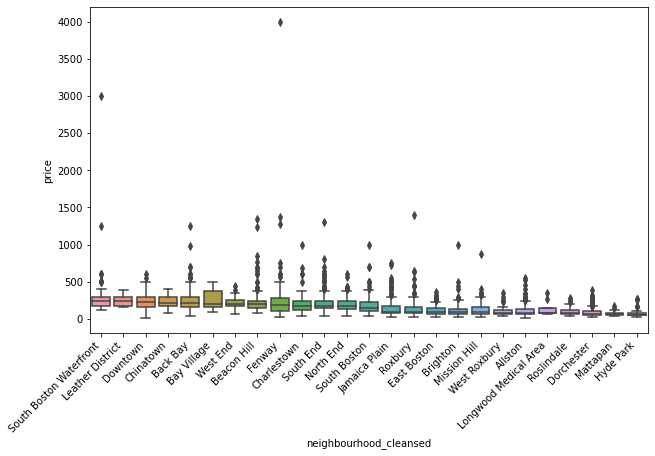

In [14]:
plt.figure(figsize = (10, 6))
order_neighbourhood=listings_dropna.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index
sns.boxplot(y=listings_dropna.price, x=listings_dropna.neighbourhood_cleansed, order=order_neighbourhood)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### Property type
Observation: Guesthouse, Boat, Villa, and Loft that can give a different experience than regular home have higher price. 

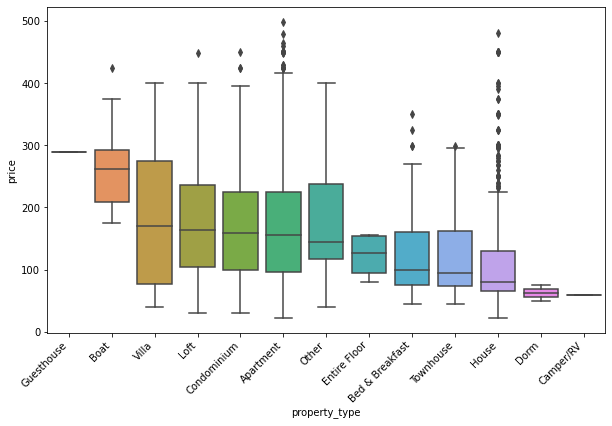

In [15]:
plt.figure(figsize = (10, 6))
order_property_type=listings_new.groupby('property_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y=listings_new.price, x=listings_new.property_type,order=order_property_type)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### Room type
Observation: As expected, entire home/apt which can offer most privacy and service has the highest price, private room with intermediate privacy is the second, and shared room with least privacy is the last. 

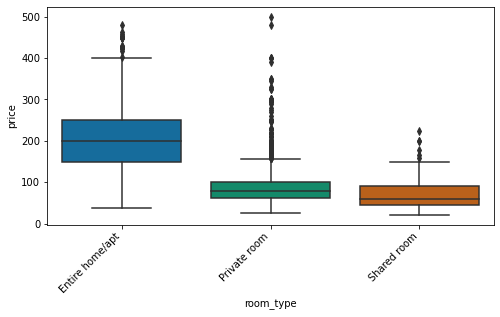

In [16]:
plt.figure(figsize = (8, 4))
order_room_type=listings_new.groupby('room_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y=listings_new.price, x=listings_dropna.room_type,order=order_room_type)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### Bed type
Observation: As expected, real bed that offers most comfort have the highest price. The more comfort the bed can offer, the higher price, which also makes sense. 

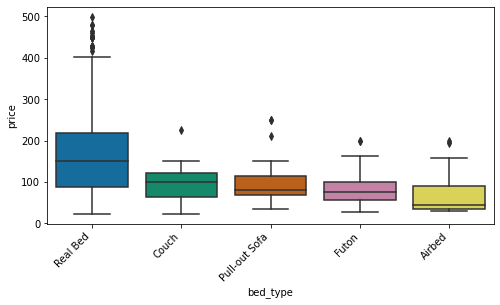

In [17]:
plt.figure(figsize = (8, 4))
order_bed_type=listings_new.groupby('bed_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y=listings_new.price, x=listings_dropna.bed_type,order=order_bed_type)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

## Heatmap for numerrical variables correlations
### Some observations from the corr heatmap between the numerical variables 
1. some mutually high correlated numerical variables:
    -  'host_total_listings_count', 'host_total_listings_count', 'calculated_host_listings_count'
    -  'availability_30', 'availability_60', 'availability_90'
2. some numerical variables that have high affect on price 
    -  'accommodates', 'bedrooms', 'beds', 'cleaning_fee'

In [18]:
# extract numerical variables, drop variables that are not affect the price, 
# fill the nan with mean, and check nan in the end
num_cols = listings_new[listings_new.select_dtypes(include=['float', 'int']).columns]
num_cols = num_cols.drop(['latitude', 'longitude'], axis=1)
num_cols = num_cols.apply(lambda col: col.fillna(col.mean()), axis=0)
num_cols.isnull().mean()

host_response_rate                0.0
host_acceptance_rate              0.0
host_listings_count               0.0
host_total_listings_count         0.0
accommodates                      0.0
bathrooms                         0.0
bedrooms                          0.0
beds                              0.0
price                             0.0
cleaning_fee                      0.0
guests_included                   0.0
extra_people                      0.0
minimum_nights                    0.0
maximum_nights                    0.0
availability_30                   0.0
availability_60                   0.0
availability_90                   0.0
availability_365                  0.0
number_of_reviews                 0.0
review_scores_rating              0.0
review_scores_accuracy            0.0
review_scores_cleanliness         0.0
review_scores_checkin             0.0
review_scores_communication       0.0
review_scores_location            0.0
review_scores_value               0.0
calculated_h

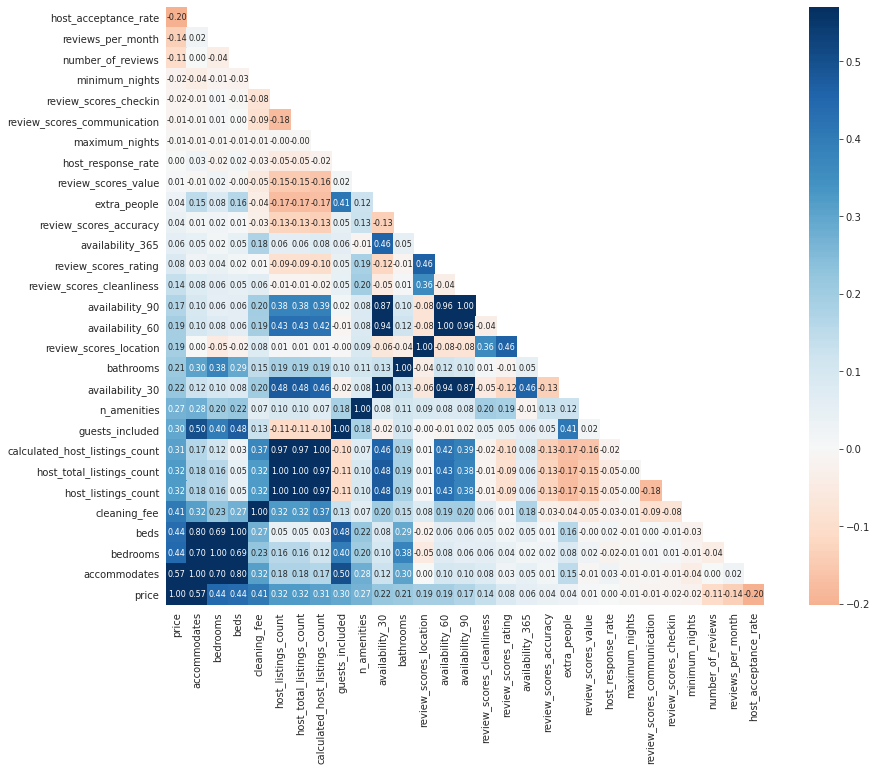

In [19]:
# heat map of corr numerical variables 
num_cols = num_cols.drop(['price'], axis=1)
num_cols = pd.concat([num_cols, listings_new['price']], axis=1)
corr = num_cols.corr().sort_values('price', axis=1, ascending=False)
corr = corr.sort_values('price', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 11))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.price.min(), 
                     vmax=corr.drop(['price'], axis=0).price.max(), center=0, square=True, 
                     annot=True, fmt='.2f',cmap='RdBu',annot_kws={"size": 8})

# Numerical and categorical variable selection

In [20]:
# function that selects variables according to the corr with price
def select_variables(data, response, num_variables, droped_variables):
    
    corr_num = data.corr()[response].abs().sort_values(ascending=False).drop(
        droped_variables)[:num_variables]
    variables = data[corr_num.index]
    
    return variables

In [21]:
# categorical variables
cat_cols_index = ['property_type','room_type','bed_type',
                  'neighbourhood_cleansed','host_is_superhost',
                  'instant_bookable','cancellation_policy',
                  'require_guest_phone_verification','require_guest_profile_picture',
                  'is_location_exact']
cat_cols = listings_new[cat_cols_index]
for col in cat_cols_index:
    cat_cols = pd.concat([cat_cols.drop(col, axis=1), 
                          pd.get_dummies(cat_cols[col], prefix=col, prefix_sep='_', 
                                                       drop_first=True)], axis=1)
cat_cols = pd.concat([listings_new['price'], cat_cols], axis=1)
cat_cols.shape

(3491, 51)

In [22]:
# select numerical variables based on the corr
# and drop the mutually high correlated variables
response = 'price'
No_num_variables = 15
high_num_correlated_variables  = ['price','host_total_listings_count',
                            'calculated_host_listings_count','availability_60',
                            'availability_90']
num_cols_selected = select_variables(num_cols, response, No_num_variables, 
                                    high_num_correlated_variables)
num_cols_new = pd.concat([num_cols['price'], num_cols_selected], axis=1)

# select categorical variables
response = 'price'
No_cat_variables = 51
cat_cols_selected = select_variables(cat_cols, response, No_cat_variables, response)
cat_cols_new = pd.concat([cat_cols['price'], cat_cols_selected], axis=1)


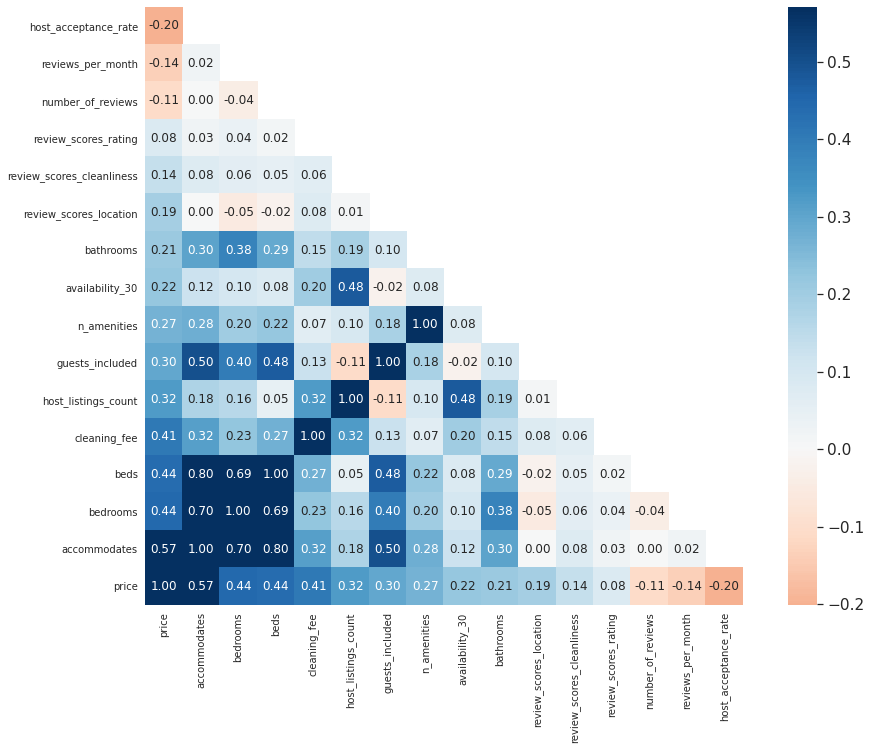

In [23]:
# heatmap of corr between the selected numerical variables and the responce price
num_corr = num_cols_new.corr().sort_values('price', axis=1, ascending=False)
num_corr = num_corr.sort_values('price', axis=0, ascending=True)
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 11))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(num_corr, mask=mask, vmin=num_corr.price.min(), 
                     vmax=num_corr.drop(['price'], axis=0).price.max(), center=0, square=True, 
                     annot=True, fmt='.2f',cmap='RdBu',annot_kws={"size": 12})

# Price estimation 
## LinearRegression
Note: 15 top corr numerical variables and 51 top corr categorical variebles are used

(3491, 65)
(3491,)
(2443, 65)
(2443,)
r2_score_test:
0.6813650886048899
r2_score_train:
0.6777049994926367


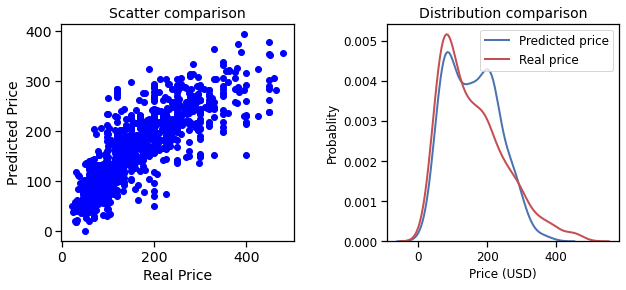

In [24]:
x = pd.concat([cat_cols_selected, num_cols_selected], axis=1)
y = num_cols.price

print (x.shape)
print (y.shape)
test_size = 0.3
random_state = 42           
# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)
print (x_train.shape)
print (y_train.shape)
lm_model = LinearRegression()
lm_model.fit(x_train, y_train)
y_test_preds = lm_model.predict(x_test)
y_train_preds = lm_model.predict(x_train)

#r2 value
r2_scores_test = r2_score(y_test, y_test_preds)
r2_scores_train = r2_score(y_train, y_train_preds)

print ('r2_score_test:')
print (r2_scores_test)
print ('r2_score_train:')
print (r2_scores_train)

fig = plt.figure(figsize =(10, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = plt.axes(aspect = 'equal')
plt.subplot(121)
plt.title('Scatter comparison', fontsize=14)
plt.scatter(y_test, y_test_preds, color='blue')
plt.xlabel('Real Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
sns.distplot(y_test_preds, hist=False,
             kde_kws={'color': 'b', 'lw': 2, 'label': 'Predicted price'})
sns.distplot(y_test, hist=False,
             kde_kws={'color': 'r', 'lw': 2, 'label': 'Real price'})
plt.title('Distribution comparison', fontsize=14)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Predicted price', 'Real price'], prop={"size":12})
plt.show()

## Find the optimal LinearRegression
Find the best combinations of the number of top corr numerical and categorical variebles 

In [25]:
def find_optimal_LR(No_num_variables, No_cat_variables, num_cols, cat_cols, response,
                    high_num_correlated_variables, test_size , random_state):
    '''
    INPUT
    No_num_variables - list of ints, number of numerical vars
    No_cat_variables - list of ints, number of categorical vars
    num_cols - pandas dataframe, numerical variavles
    cat_cols - pandas dataframe, categorical variavles
    response - str, column name of the response
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    

    OUTPUT
    results - dictionary of r2 scores for different combination of number of numerical and categorical variables
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    best_r2_score_test - float, best r2 score on the test data
    best_num_variables - int, number of numerical variables for best r2 score 
    best_cat_variables - int, number of categorical variables for best r2 score 
    best_lm_model - optimal model object from sklearn
    best_x_train, best_x_test, best_y_train, best_y_test - output from sklearn train test split used for optimal model
    '''
    
    best_r2_score_test, best_num_variables, best_cat_variables, best_lm_model = 0, 0, 0, []
    best_x_train, best_x_test, best_y_train, best_y_test = [], [], [], []
    r2_scores_test, r2_scores_train, results = [], [], dict()
    for No_num in No_num_variables:
        for No_cat in No_cat_variables:
            num_cols_selected = select_variables(num_cols, response, No_num, 
                                    high_num_correlated_variables)
            cat_cols_selected = select_variables(cat_cols, response, No_cat, response)
            x = pd.concat([cat_cols_selected, num_cols_selected], axis=1)
            y = num_cols.price
            
            # split the data into train and test
            x_train, x_test, y_train, y_test = \
            train_test_split(x, y, test_size = test_size, random_state = random_state)
            
            # fit the model and obtain pred response
            lm_model = LinearRegression()
            lm_model.fit(x_train, y_train)
            y_test_preds = lm_model.predict(x_test)
            y_train_preds = lm_model.predict(x_train)
            
            # record the best model
            r2_score_test = r2_score(y_test, y_test_preds)
            if r2_score_test > best_r2_score_test:
                best_r2_score_test = r2_score_test
                best_num_variables = No_num
                best_cat_variables = No_cat
                best_lm_model = lm_model
                best_x_train, best_x_test, best_y_train, best_y_test \
                = x_train, x_test, y_train, y_test
                
            # append the r2 value from the test set
            r2_scores_test.append(r2_score_test)
            r2_scores_train.append(r2_score(y_train, y_train_preds))
            variables = str(No_num) + ' num_variables,' + str(No_cat) + ' cat_variables'
            results[variables] = r2_score(y_test, y_test_preds)

    return results, r2_scores_test, r2_scores_train, best_r2_score_test, best_num_variables, \
        best_cat_variables, best_lm_model, best_x_train, best_x_test, best_y_train, best_y_test


In [26]:
response = 'price'
No_num_variables = list(range(1, 20))
No_cat_variables = [10, 15, 20, 25, 30, 35, 40, 45, 51]
test_size = 0.3
random_state=42
# find the best combination of selection of numerical and categorical variables,  
# and return the corresponding x_train, x_test, y_train, y_test
results, r2_scores_test, r2_scores_train, best_r2_score_test, best_num_variables, \
    best_cat_variables, best_lm_model, x_train, x_test, y_train, y_test \
    = find_optimal_LR(No_num_variables, No_cat_variables, num_cols, cat_cols, response, 
                      high_num_correlated_variables, test_size , random_state)
print ('best_r2_score_test:')
print (best_r2_score_test)
print ('best_num_variables:')
print (best_num_variables)
print ('best_cat_variables:')
print (best_cat_variables)

best_r2_score_test:
0.6820983963263165
best_num_variables:
18
best_cat_variables:
51


r2_score_test:
0.6820983963263165
r2_score_train:
0.6778399173533587


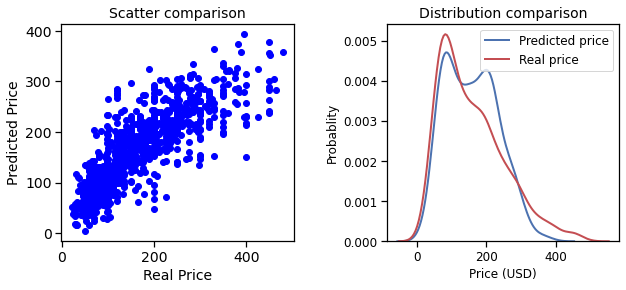

In [27]:
lm_model = LinearRegression()
lm_model.fit(x_train, y_train)
y_test_preds = lm_model.predict(x_test)
y_train_preds = lm_model.predict(x_train)

#r2 value
r2_scores_test = r2_score(y_test, y_test_preds)
r2_scores_train = r2_score(y_train, y_train_preds)

print ('r2_score_test:')
print (r2_scores_test)
print ('r2_score_train:')
print (r2_scores_train)

fig = plt.figure(figsize =(10, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = plt.axes(aspect = 'equal')
plt.subplot(121)
plt.title('Scatter comparison', fontsize=14)
plt.scatter(y_test, y_test_preds, color='blue')
plt.xlabel('Real Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
sns.distplot(y_test_preds, hist=False,
             kde_kws={'color': 'b', 'lw': 2, 'label': 'Predicted price'})
sns.distplot(y_test, hist=False,
             kde_kws={'color': 'r', 'lw': 2, 'label': 'Real price'})
plt.title('Distribution comparison', fontsize=14)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Predicted price', 'Real price'], prop={"size":12})
plt.show()

# RidgeCV 
1. Explore that if RidgeCV can improve the estimation accuracy since the data contains variables that highly correlated. Through adding bias, the variance of the estimates can be reduced. 
2. Thorugh observing the results, it turns out that the r2 score for the test data has been improved very subtlely.

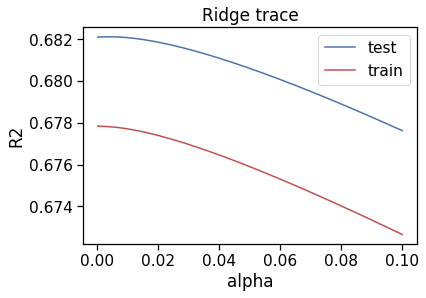

In [28]:
alphas = np.linspace(0.0001,0.1,200)
from sklearn.metrics import mean_squared_error
ridge_cofficients = []
r2_scores_test = []
r2_scores_train = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha, normalize=True)
    ridge.fit(x_train, y_train)
    y_test_preds = ridge.predict(x_test)
    r2_score_test = r2_score(y_test, y_test_preds)
    r2_scores_test.append(r2_score_test)
    y_train_preds = ridge.predict(x_train)
    r2_score_train = r2_score(y_train, y_train_preds)
    r2_scores_train.append(r2_score_train)

fig = plt.figure(1)
fig.set_facecolor('white') 
plt.plot(alphas, r2_scores_test, 'b', label = 'test')
plt.plot(alphas, r2_scores_train, 'r', label = 'train')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.axis('tight')
plt.title('Ridge trace')
plt.legend()
plt.show()  

In [29]:
# coss-validation test
ridge_cv = RidgeCV(alphas = alphas, normalize=True, cv = 5)
# , scoring="neg_mean_squared_error")
ridge_cv.fit(x_train, y_train)
# find the best alpha
alpha = ridge_cv.alpha_
print ('best alpha:')
print (alpha)

best alpha:
0.015662311557788945


r2_score_test:
0.6819704071181732
r2_score_train:
0.677547465181417


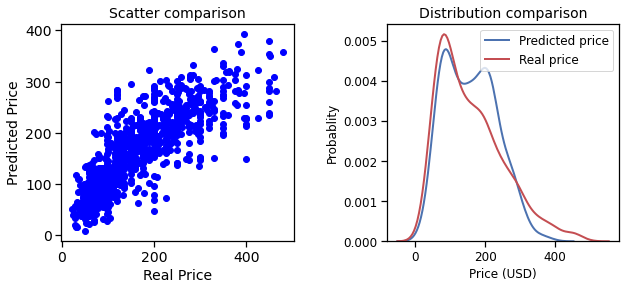

In [30]:
# lm_model = LinearRegression()
lm_model = Ridge(alpha = alpha, normalize=True)
lm_model.fit(x_train, y_train)
y_test_preds = lm_model.predict(x_test)
y_train_preds = lm_model.predict(x_train)

#r2 value
r2_scores_test = r2_score(y_test, y_test_preds)
r2_scores_train = r2_score(y_train, y_train_preds)

print ('r2_score_test:')
print (r2_scores_test)
print ('r2_score_train:')
print (r2_scores_train)

fig = plt.figure(figsize =(10, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = plt.axes(aspect = 'equal')
plt.subplot(121)
plt.title('Scatter comparison', fontsize=14)
plt.scatter(y_test, y_test_preds, color='blue')
plt.xlabel('Real Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['KDE'], prop={"size":12})
# plt.show()

plt.subplot(122)
sns.distplot(y_test_preds, hist=False,
             kde_kws={'color': 'b', 'lw': 2, 'label': 'Predicted price'})
sns.distplot(y_test, hist=False,
             kde_kws={'color': 'r', 'lw': 2, 'label': 'Real price'})
plt.title('Distribution comparison', fontsize=14)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Predicted price', 'Real price'], prop={"size":12})
plt.show()

# Summaries and conclusions
In this article, we took a look at what and how the factors will affect the listing price according to Boston Airbnb listing data from 2019.

1. The top 3 numerical factors affect the price are all functionality related factors such as number of accommodates, bedrooms, and beds. All of the three factors have positive effects on the listing price.
2. In addition, other factors including the neighborhood, property type, bed type, room type, and cancellation policy also affects the listing price. Overall, the more service, comfort and privacy the listing property can offer, the higher the price.
3. Finally, a price estimator based on linear regression is developed and optimized. The best test r2 score is o.682, which is not a high accuracy. The reason behind that might be there are so many variables in the data and some of them are highly correlated.